In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import scipy
import pywt
import mne
import math

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
from stats_utils import *
import glob
import os


import seaborn as sns
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Wavelet for one subject, all channels

In [831]:
sub = '01'
period = 'pre'
task = 'listen'
channels = 'allch' #allch or other options

wavelet_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz_{channels}/'
data = loadmat(os.path.join(wavelet_path, f'{task}_wavelet_{period}_{sub}.mat'))
wavelet_transform = data['wavelet_transform']

wavelet_trans_info = loadmat(os.path.join(wavelet_path,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

wavelet_transform_mean = np.mean(wavelet_transform, axis = 0)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_listen__n05to05_30Hz_allch/listen_wavelet_pre_01.mat'

#### Plot scaleogram for one channel

Text(0.5, 1.0, 'Cz channel, listen pre sub 01')

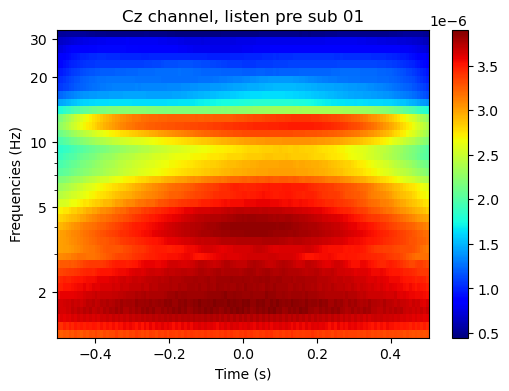

In [ ]:
channel = ['Cz']
ch_idx = ch_index(channel)
#ch_idx = 0 #working on arrays with only one channel index


test_wavelet = np.squeeze(wavelet_transform_mean[ch_idx,:,:])
plot_scaleogram(test_wavelet, freqs, times) 
plt.title(f'{channel[0]} channel, {task} {period} sub {sub}')

#### Plot topomap for a frequency band

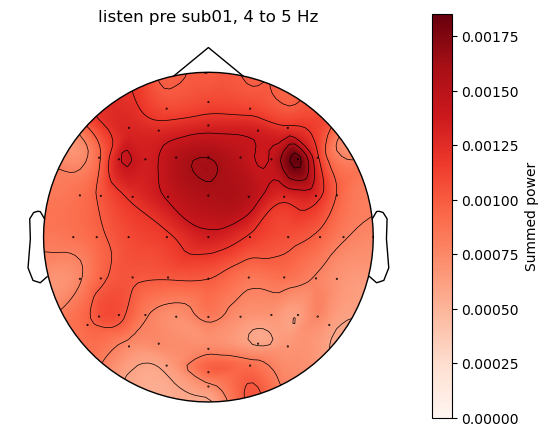

In [ ]:
freq_band = [4,5] #10-15 for beta, 4-5 for listening-related ERP
power_ch = sum_over_channels(wavelet_transform_mean, freq_band, freqs)

fig, ax = plt.subplots()
ax.set_title(f'{task} {period} sub{sub}, {freq_band[0]} to {freq_band[1]} Hz')


#plot this last
pos = load_ep_info()
im, _=mne.viz.plot_topomap(power_ch, pos, axes = ax, show = False)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Summed power')




In [ ]:
wavelet_transform_mean.shape

(64, 40, 129)

Text(0.5, 0, 'freqs')

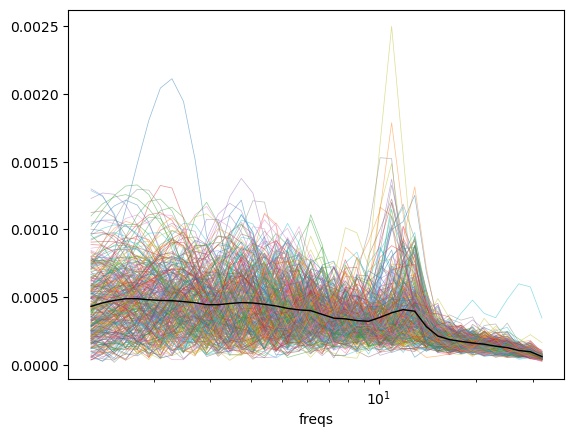

In [ ]:
#try to look at variability
wavelet_transform.shape

for trial in range(wavelet_transform.shape[0]):
    wavelet_trial = wavelet_transform[trial, 47, :,:].squeeze()
    trial_sum = np.sum(wavelet_trial, axis = 1)
    trial_sum.shape
    plt.plot(freqs, trial_sum, linewidth = 0.5, alpha = 0.5)

plt.plot(freqs, np.sum(wavelet_transform_mean[47], axis = 1), color = 'black', linewidth = 1)

plt.xscale('log')
plt.xlabel('freqs')

### Wavelet for multiple subjects listen and motor

In [69]:
task = 'listen'
ch_to_visualize = ['Cz']

wavelet_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz_all_ave'
subjects_to_process = find_existing_subjects(wavelet_dir)
#subjects_to_process = ['13', '18', '12', '02']
print('processing subjects', subjects_to_process)

wavelet_trans_info = loadmat(os.path.join(wavelet_dir,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

processing subjects ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']


##### Initialize directories

In [71]:
"""period = 'pre'
task = 'listen'
channels = 'Cz'"""

power_df_all = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
#power_df_45 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[4,5])
#power_df_1220 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[12,20])

#power_musicians_pre = power_df_all.query("musician == 1 & period == 'pre'")
#power_musicians_post = power_df_all.query("musician == 1 & period == 'post'")
#power_nonmusicians_pre = power_df_all.query("musician == 0 & period == 'pre'")
#power_nonmusicians_post = power_df_all.query("musician == 0 & period == 'post'")

power_all_pre = power_df_all.query("period == 'pre'")
power_all_post = power_df_all.query("period == 'post'")

skipping sub record


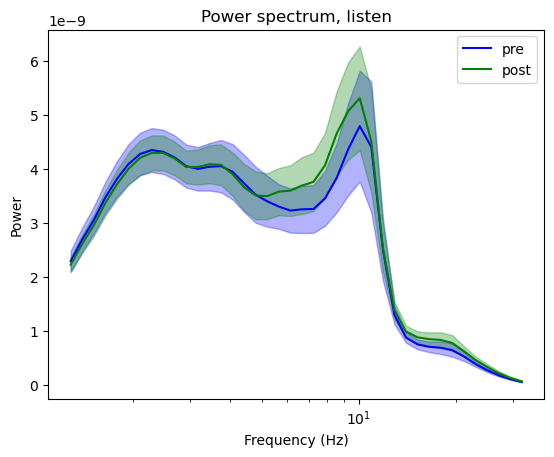

In [72]:
plot_power_freqs(freqs, power_all_pre, color = 'blue', label = 'pre')
plot_power_freqs(freqs, power_all_post, color = 'green', label = 'post')
plt.title(f'Power spectrum, {task}')
plt.legend()


Difference in power

In [73]:
power_diff = power_all_post['power']-power_all_pre['power']
power_diff = np.vstack(power_diff)

Text(0.5, 1.0, 'Motor difference post-pre, good musicians')

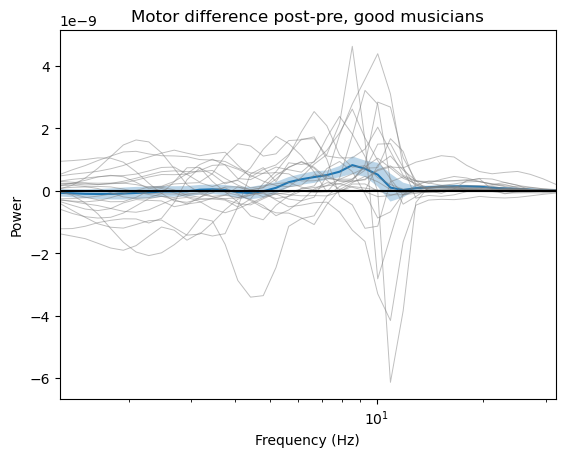

In [74]:
plot_power_freqs(freqs,power_diff)
for sub in range(power_diff.shape[0]):
    plt.plot(freqs, power_diff[sub, :], color = 'grey', alpha = 0.5, linewidth = 0.7)
plt.hlines(0,freqs[-1], freqs[0], color = 'black')
plt.xlim(freqs[-1], freqs[0])
plt.title(f'Motor difference post-pre, good musicians')

In [75]:
test_stats, p_values = t_within_points(power_diff)

testing gaussianity over 21 points
Distribution is not normal. p =  2.2241191184921992e-05
using wilcoxon test


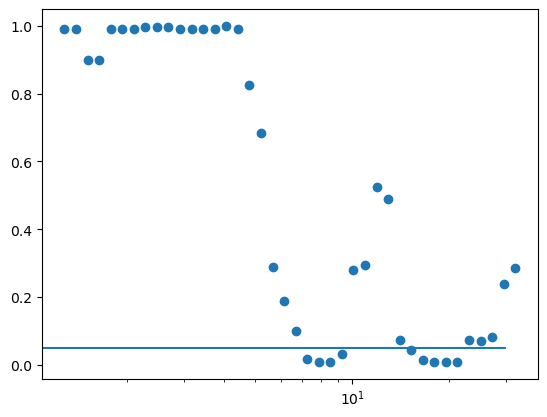

In [76]:
plt.scatter(freqs, p_values)
plt.hlines(0.05, 0, 30)
plt.xscale('log')

Text(0.5, 1.0, 'Listen difference post-pre (all subjects)')

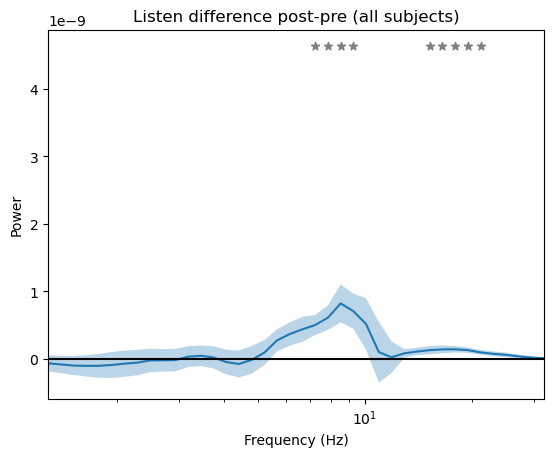

In [99]:
sig_idx = [i for i, p in enumerate(p_values) if p < 0.05]

plot_power_freqs(freqs, power_diff)
plt.hlines(0,freqs[-1], freqs[0], color = 'black')
plt.xlim(freqs[-1], freqs[0])

sig_y_pos = np.max(power_diff)
plt.scatter(freqs[sig_idx], [sig_y_pos]*len(sig_idx), marker = "*", color = 'grey')
plt.title(f'Listen difference post-pre (all subjects)')

bootstrap

In [80]:
from scipy.stats import ttest_1samp, wilcoxon, bootstrap
from statsmodels.stats.multitest import fdrcorrection
import numpy as np

def bootstrap_t_within_points(array, n_resamples=1000, confidence_level=0.95):
    """ 
    Compare within-subjects samples along an axis of points (e.g. times or freqs)
    using bootstrapping for statistical analysis.
    
    Parameters:
    - array: array of shape (n_subs, n_points)
    - n_resamples: number of bootstrap resamples
    - confidence_level: confidence level for bootstrap intervals
    
    Returns:
    - test_stats: mean test statistics for each point
    - p_values: adjusted p-values for each point
    - ci_lower: lower bounds of the bootstrap confidence intervals
    - ci_upper: upper bounds of the bootstrap confidence intervals
    """
    n_subs, n_points = array.shape
    ks = gaussian_test(array, axis=0)

    if ks > 0.05:
        print('using 1samp ttest')
        test_function = lambda data: ttest_1samp(data, popmean=0).statistic
    else:
        print('using wilcoxon test')
        test_function = lambda data: wilcoxon(data).statistic

    ci = []
    distr = []


    for point in range(n_points):
        data = array[:, point]
        
        # Bootstrap resampling
        res = bootstrap(
            data=(data,), 
            statistic=test_function, 
            vectorized=False, 
            n_resamples=n_resamples,
            confidence_level=confidence_level
        )
        
        # Extract statistics and confidence intervals
        ci.append(res.confidence_interval)
        distr.append(res.bootstrap_distribution)
        
    # Apply FDR correction to p-values
    #p_values = fdrcorrection(p_values)[1]

    return ci, distr


In [81]:
ci, distr = bootstrap_t_within_points(power_diff, n_resamples=10)

testing gaussianity over 21 points
Distribution is not normal. p =  2.2241191184921992e-05
using wilcoxon test


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/scipy/stats/_resampling.py:153: RuntimeWarning: invalid value encountered in scalar divide
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/scipy/stats/_resampling.py:155: RuntimeWarning: invalid value encountered in scalar divide
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


In [82]:
distr

[array([ 39.,  99.,  70.,  87.,  60., 106.,  82., 110.,  25.,  60.]),
 array([92., 52., 79., 31., 70., 56., 89., 88., 60., 43.]),
 array([91., 40., 39., 78., 51., 62., 78., 39., 47., 49.]),
 array([60., 71., 49., 22., 67., 12., 30., 24., 84., 55.]),
 array([ 60.,  35.,  29., 109.,  98.,  49.,  76.,  46.,  82.,  62.]),
 array([ 0., 23.,  7., 18., 45.,  1.,  1., 18., 45., 38.]),
 array([49., 17., 36., 26., 35., 23.,  1., 24., 37., 30.]),
 array([21., 56., 16.,  3., 24., 10., 13., 17., 19., 11.]),
 array([44., 48.,  6., 33., 77., 76., 30., 45., 42., 29.]),
 array([93., 53., 81., 36., 30., 73., 45., 55., 61., 68.]),
 array([81., 91., 84., 22., 68., 49., 12., 63., 56., 52.]),
 array([ 77., 110.,  65.,  33.,  74.,  87.,  54., 100.,  84.,  77.]),
 array([45., 54., 88., 76., 37., 98., 57., 44., 66., 91.]),
 array([ 33.,  53.,  66.,  68.,  22.,  36., 105.,  49.,  50.,  86.]),
 array([ 93.,  55., 101.,  98., 108.,  73.,  87., 112.,  78.,  72.]),
 array([75., 79., 40., 26., 17., 31., 58., 31., 37

In [83]:
[freqs[1]]*10

[29.464926542347584,
 29.464926542347584,
 29.464926542347584,
 29.464926542347584,
 29.464926542347584,
 29.464926542347584,
 29.464926542347584,
 29.464926542347584,
 29.464926542347584,
 29.464926542347584]

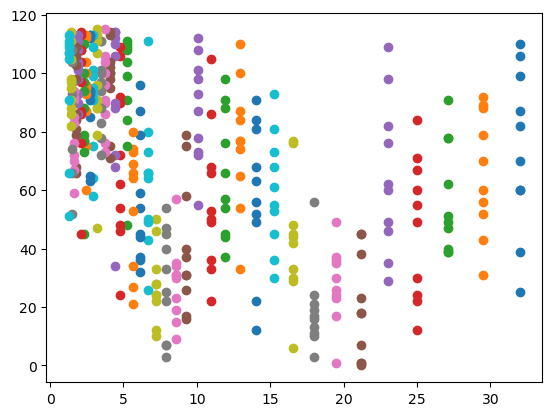

In [84]:

for i in range(len(distr)):
    plt.scatter([freqs[i]]*10,distr[i])

#### Mus vs nmus

In [85]:
def find_power_diff(power_df):
    """ 
    Finds post-pre values for a given power dataframe
    ---
    Returns a dataframe with pre, post, and difference
        TO DO: get rid of the pre and post to save on memory??
    """
    power_pivot = power_df.pivot(index =[ 'subject', 'musician'], columns = 'period', values = 'power')
    power_pivot['diff'] = power_pivot['post'] - power_pivot['pre']
    return power_pivot

In [86]:
power_diff_1220 = find_power_diff(power_df_1220)
power_diff_45 = find_power_diff(power_df_45)

Text(0.5, 1.0, 'Power difference post - pre, 12-20 Hz')

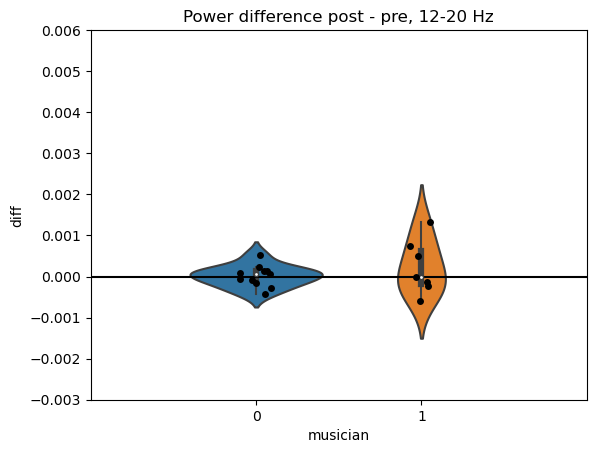

In [87]:
sns.violinplot(data=power_diff_1220, x = power_diff_1220.index.get_level_values(1), y = 'diff')
sns.stripplot(data=power_diff_1220, x = power_diff_1220.index.get_level_values(1), y = 'diff', color = 'black')
plt.hlines(0, -1,2, color = 'black')

plt.xlim(-1,2)
plt.ylim(-0.003, 0.006)
plt.title('Power difference post - pre, 12-20 Hz')


Power over a band

(0.0, 0.008)

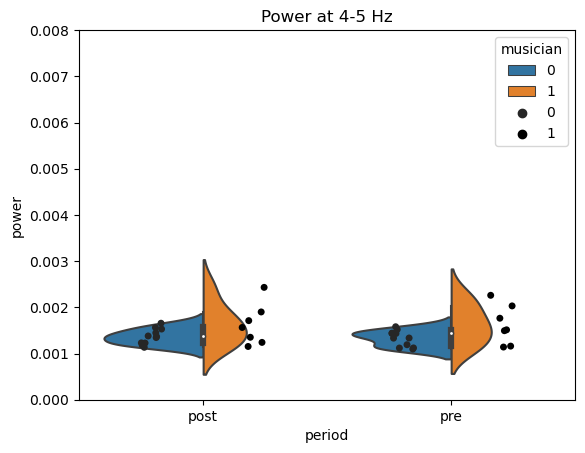

In [88]:
sns.violinplot(data = power_df_45, x = 'period', y = 'power', hue = 'musician', split = True)
sns.stripplot(data = power_df_45, x = 'period', y = 'power', hue = 'musician', color = 'black', dodge=True)
plt.title('Power at 4-5 Hz')
plt.ylim(0, 0.008)

#### Topomap

In [89]:
def power_over_channels(subjects_to_process, wavelet_dir, freq_band, period = None):
    """ 
    Extracts the power at each channel in a specified band, makes the data ready to topoplot
    freq_band: list of freqs representing lower and upper bound
    period: 'pre' or 'post'. If None, combines the two periods
    ---
    Returns array of size n_subjects x n_channels
    """
    info_path = os.path.join(wavelet_dir, "wavelet_record.mat")
    wavelet_trans_info = loadmat(info_path)
    freqs = wavelet_trans_info['freqs'][0]

    _, _, musicians, _ = load_subject_lists()

    wavelet_sum_list = []
    for wavelet_file in sorted(os.listdir(wavelet_dir)):
            
        sub_id = wavelet_file.split(".")[0].split('_')[-1]
        if sub_id not in subjects_to_process:
            print(f'skipping sub {sub_id}')
            continue
        
        #check the period. 
        if period != None:
            sub_period =  wavelet_file.split(".")[0].split('_')[-2]
            if sub_period != period:
                continue
    
        
        data = loadmat(os.path.join(wavelet_dir, wavelet_file))
        wavelet_sub = data['wavelet_transform']
      

        freq_idx = index_custom(freq_band, freqs)
        wavelet_sub_freq = wavelet_sub[:, np.min(freq_idx):np.max(freq_idx), :]
        
        wavelet_sum = np.sum(wavelet_sub_freq, axis = (1,2))
        wavelet_sum_list.append(wavelet_sum)
    
    wavelet_sum_arr = np.array(wavelet_sum_list)
    
    return wavelet_sum_arr





In [90]:
def plot_topo_custom(topo_data, pos, colorbar=False, title = None):
    """  
    uses mne plot topo function to plot a nice topomap with my favourite parameters 
    NOT COMPLETELY POLISHED BUT USABLE
    """
    fig, ax = plt.subplots()
    im, _ = mne.viz.plot_topomap(topo_data, pos, axes=ax, show=False)
    if colorbar:
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7)
        cbar.set_label('Amplitude (µV)', rotation=270, labelpad=15) 

    if title != None:
        ax.set_title(title)
    plt.show()

skipping sub record


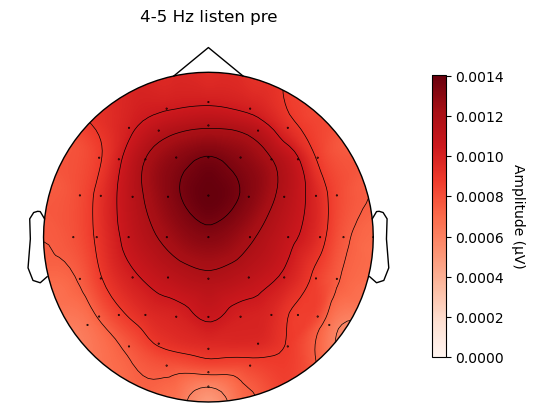

In [91]:
pos = load_ep_info()
period = 'pre'

topo_45 = power_over_channels(subjects_to_process, wavelet_dir, [4,5], period)
topo_45_mean = np.mean(topo_45, axis = 0)
plot_topo_custom(topo_45_mean, pos, colorbar=True, title = f'4-5 Hz {task} {period}')



skipping sub record


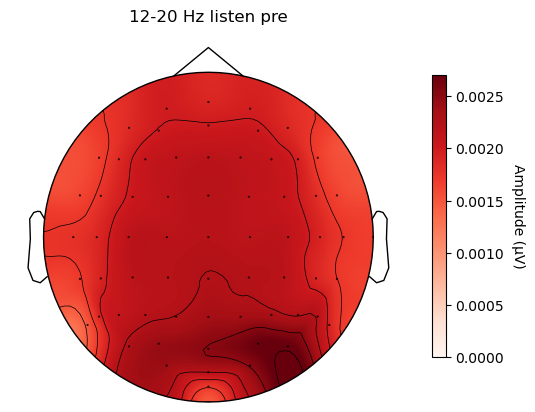

In [92]:
topo_1220 = power_over_channels(subjects_to_process, wavelet_dir, [10,15], period)
topo_1220_mean = np.mean(topo_1220, axis = 0)
plot_topo_custom(topo_1220_mean, pos, colorbar=True, title = f'12-20 Hz {task} {period}')


In [93]:


def plot_over_subs(data, pos, sup_title = None):
    n_subs = data.shape[0]
    
    # Determine grid size (rows and columns)
    n_cols = math.ceil(np.sqrt(n_subs))
    n_rows = math.ceil(n_subs / n_cols)
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = np.array(axes).flatten()  # Flatten axes for easier indexing
    
    for sub in range(n_subs):
        topo_sub = data[sub, :]
        
        # Plot the topomap for each subject
        mne.viz.plot_topomap(topo_sub, pos, axes=axes[sub], show=False)
        axes[sub].set_title(f"Sub {sub + 1}")
    
    # Hide unused subplots
    for ax in axes[n_subs:]:
        ax.axis('off')
    
    if sup_title!= None:
        fig.suptitle(sup_title, fontsize = 20)

    plt.tight_layout()
    plt.show()
    


In [94]:
#plot_over_subs(topo_1220, pos, sup_title=f'{task} {period} 12-20 Hz')
#plot_over_subs(topo_45, pos, sup_title=f'{task} {period} 4-5 Hz')


## Wavelet for multiple subjects training

In [95]:
task = 'training'
ch_to_visualize = ['Cz']

wavelet_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz_all_ave'
subjects_to_process = find_existing_subjects(wavelet_dir)
print('processing subjects', subjects_to_process)

wavelet_trans_info = loadmat(os.path.join(wavelet_dir,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()
##### Initialize directories
"""period = 'pre'
task = 'listen'
channels = 'Cz'"""


processing subjects ['05', '06', '07', '08', '09', '10', '11', '12']


"period = 'pre'\ntask = 'listen'\nchannels = 'Cz'"

In [96]:

power_df_all = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
power_df_45 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[4,5])
power_df_1220 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[12,20])


skipping sub record
skipping sub record
skipping sub record


In [97]:
power_mus_train = power_df_all.query('musician == 1')
power_nmus_train = power_df_all.query('musician == 0')

In [98]:
plot_power_freqs(freqs, power_mus_train, color = 'blue', label = 'mus', normalize = True)
plot_power_freqs(freqs, power_nmus_train, color = 'orange', label = 'nmus', normalize=True)
plt.legend()
plt.title('training (normalized)')

TypeError: plot_power_freqs() got an unexpected keyword argument 'normalize'

## Comparing listen motor to training

In [ ]:
ch_to_visualize = ['Cz']

wavelet_dir_l = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_listen__n05to05_30Hz_all_ave'
wavelet_dir_m = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_motor__n05to05_30Hz_all_ave'
wavelet_dir_t = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_training__n05to05_30Hz_all_ave'

#use motor folder as reference because the subjects are more limited
subjects_to_process = find_existing_subjects(wavelet_dir_m)
print('processing subjects', subjects_to_process)

wavelet_trans_info = loadmat(os.path.join(wavelet_dir_m,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()
##### Initialize directories
"""period = 'pre'
task = 'listen'
channels = 'Cz'"""

power_df_all_l = power_over_subs(subjects_to_process, wavelet_dir_l, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
power_df_all_m = power_over_subs(subjects_to_process, wavelet_dir_m, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
power_df_all_t = power_over_subs(subjects_to_process, wavelet_dir_t, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)


power_mus_pre_l = power_df_all_l.query("musician == 1 & period == 'pre'")
power_mus_post_l = power_df_all_l.query("musician == 1 & period == 'post'")
power_mus_pre_m = power_df_all_m.query("musician == 1 & period == 'pre'")
power_mus_post_m = power_df_all_m.query("musician == 1 & period == 'post'")

power_nmus_pre_l = power_df_all_l.query("musician == 0 & period == 'pre'")
power_nmus_post_l = power_df_all_l.query("musician == 0 & period == 'post'")
power_nmus_pre_m = power_df_all_m.query("musician == 0 & period == 'pre'")
power_nmus_post_m = power_df_all_m.query("musician == 0 & period == 'post'")

processing subjects ['01', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '18', '19', '20']
skipping sub 02
skipping sub 17
skipping sub 21
skipping sub 02
skipping sub 17
skipping sub 21
skipping sub record
skipping sub record
skipping sub record


In [ ]:
power_mus_pre_lm = np.array(power_mus_pre_l['power'].tolist()) + np.array(power_mus_pre_m['power'].tolist())


In [ ]:
power_t = np.array(power_df_all_t['power'].tolist()) 

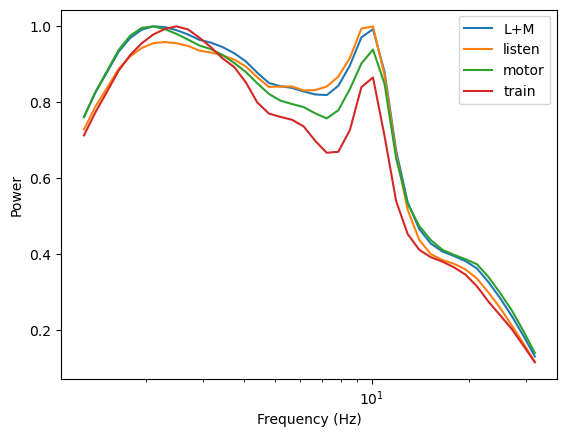

In [ ]:
#norm_l_mus_pre = power_mus_pre_l.mean(axis = 0)
normalize = True
plot_power_freqs(freqs,power_nmus_pre_lm, normalize= normalize, label = 'L+M')
plot_power_freqs(freqs, power_nmus_pre_l, normalize=normalize, label = "listen")
plot_power_freqs(freqs, power_nmus_pre_m, normalize=normalize, label = 'motor')
plot_power_freqs(freqs, power_t, normalize=normalize, label = 'train')
plt.xscale('log')
plt.legend()